In [21]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import scipy.linalg as la
import math
from numpy import random
import cmath
import time
from sympy import S, symbols, printing

### Hamiltonian Generation

In [3]:
epsilon = 0.01
X = np.array([[0, 1],
     [1, 0]])
Z = np.array([[1, 0],
     [0, -1]])
I = np.array([[1, 0],
     [0, 1]])
XX = np.kron(X, X) #tensor products between two Pauli's
XZ = np.kron(X, Z)
ZZ = np.kron(Z, Z)
ZX = np.kron(Z, X)
II = np.kron(I, I)
IX = np.kron(I, X)
XI = np.kron(X, I)

In [4]:
#List of Hamiltonian decomposition terms H_j for H = \sum_j h_j H_j
Hlist = np.array([XX, XZ, ZX, ZZ, IX])
hj = [1.0, 2.0, 3.0, 4.0, 2.0] #list of normalized coefficients
lambd = sum(hj)
#t = 10
gamma = 2
alphacomm = 4 * lambd**3
#r = int(((t**3)* 4 * (gamma**4))/(epsilon * 3)) #omitted alphacomm might be prohibitive

L = len(hj) #number of terms in the Hamiltonian
InitialState = [1/(2**(1/2)), 0, 1/(2**(1/2)), 0]
print(Hlist.shape)

(5, 4, 4)


### Trotter-Suzuki Second Order Simulation

In [5]:
def S2Trotter(Hlist, t, r): #Creates a list of all of the evolution operators in 2nd order Trotter-Suzuki
    U = []
    for i in range(0, L):
        U.append((math.cos(t*hj[i]/(2*r)))*(II) - 1j*math.sin(t*hj[i]/(2*r))*Hlist[i, :, :])
    for i in range(1, L+1): 
        U.append((math.cos(t*hj[-i]/(2*r)))*(II) - 1j*math.sin(t*hj[-i]/(2*r))*Hlist[-i, :, :])
    return U #Takes in Hamiltonian terms and converts them each into evolution operators

In [6]:
def S2TrotterAuto(Hlist, t, r):
    U = []
    for i in range(0, L):
        U.append(la.expm(-1j*hj[i]*t*Hlist[i, :, :]/(2*r)))
    for i in range(1, L+1):
        U.append(la.expm(-1j*hj[-i]*t*Hlist[-i, :, :]/(2*r)))
    return U

In [7]:
def S2_Comp(OperatorCoeffs, OperatorList, t, r, TrueState): #Applies each of the evolution operators storing the previous state in a matrix row
    TrotterOps = S2Trotter(Hlist, t, r)
    infidelity = 0
    dim = len(TrotterOps)
    Psi = np.zeros((4), dtype = complex)
    Psi = InitialState
    for i in range(0, (dim*r)):
        Psi = TrotterOps[i%dim] @ Psi # %8 is because one application of S2 trotter has 8 ops when N=4, also = 2L
    
    infidelity = 1- (np.abs(TrueState @ np.conjugate(Psi)))**2
    
    return infidelity

In [8]:
def S2_CompAuto(OperatorCoeffs, OperatorList, t, r, TrueState): #Applies each of the evolution operators storing the previous state in a matrix row
    TrotterOps = S2TrotterAuto(Hlist, t, r)
    infidelity = 0
    dim = len(TrotterOps)
    Psi = np.zeros((4), dtype = complex)
    Psi = InitialState
    for i in range(0, (dim*r)):
        Psi = TrotterOps[i%dim] @ Psi # %8 is because one application of S2 trotter has 8 ops when N=4, also = 2L
    
    infidelity = 1- (np.abs(TrueState @ np.conjugate(Psi)))**2
    
    return infidelity

### QDRIFT Simulator

In [46]:
lambd = sum(hj)
#N = int(2*(lambd**2)*(t**2)/epsilon)
#tau = t*lambd/N
def QdriftPool(Hlist,t, N):
    tau = t*lambd/N
    dim = len(Hlist)
    U = []
    for i in range(0, dim):
        U.append((math.cos(tau))*(II) - 1j*math.sin(tau)*Hlist[i, :, :])
    return U

def SumRange(hj, m, n):
    #list of terms hj, m, n the min and max of the sum range
    l = 0
    for i in range(m, n):
          l += hj[i]
    return l

In [47]:
def QDRIFT_comp(OperatorCoeffs, OperatorBin, N, t, TrueState): #same as the above function but does not store intermediate states
    Psi = np.zeros((4), dtype = complex)
    DriftOps = QdriftPool(Hlist, t, N)
    Psi = InitialState
    fidelity = 0
    for i in range(0, N):
        x = random.rand()
        for j in range(L):
            if SumRange(hj, 0, j)/lambd < x <= SumRange(hj, 0, j+1)/lambd:
                    Psi = DriftOps[j] @ Psi
                    p_i = hj[j]/lambd
            else:
                pass
        
    infidelity = 1 - (np.abs(TrueState @ np.conjugate(Psi)))**2
    
    return infidelity

### Solution by exact diagonalization

In [13]:
def HamiltonianMat(Hlist, hj): #just makes one hamiltonian matrix based on the lists
    U = []
    for i in range (0, L):
        U.append(hj[i]*Hlist[i, :, :])
    H = sum(U)
    return H
print(H)

[[ 4.  5.  2.  1.]
 [ 5. -4.  1. -2.]
 [ 2.  1. -4. -1.]
 [ 1. -2. -1.  4.]]


In [12]:
H = HamiltonianMat(Hlist, hj)
(Y,V) = la.eigh(H) #Diagonalizes the hamiltonian
print(Y)
#This calculates the eigen vectors V and the eigenvalues Y of the Hamiltonian. Note: the eigenvalues are ordered.

[-6.87506358 -4.55340541  4.55340541  6.87506358]


In [14]:
V_i = np.array(V, dtype = complex)
V_i_dagger = np.conjugate(V_i.T)
Psi_t = (V_i) @ np.diag(np.exp(-1j*Y*1)) @ V_i_dagger @ InitialState #evolves the system by applying U directly
print(InitialState @ np.conjugate(InitialState))

0.9999999999999998


### QDRIFT Performance

In [52]:
#Test the simulator for varying t
startTime = time.time()

tStart = 0.01
tFinal = 10
tSteps = 50
times = np.linspace(tStart, tFinal, tSteps)

#N = int(2*(lambd**2)*(tFinal**2)/epsilon)
N = 10000
infidel_t = []

for t in times:
    Psi_t = (V_i) @ np.diag(np.exp(-1j*Y*t)) @ V_i_dagger @ InitialState #recalculate the exact solution
    infidel = QDRIFT_comp(hj, Hlist, N, t, Psi_t)
    infidel_t.append(infidel)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 3.3567469120025635


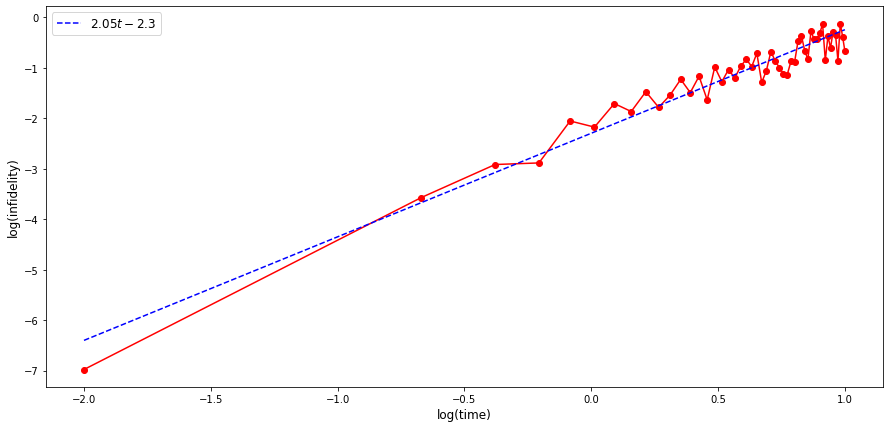

In [53]:
log_infidelity = np.log10(infidel_t)
log_time = np.log10(times)

plt.figure (figsize = (15, 7))
plt.plot(log_time, log_infidelity, 'ro-') 
plt.xlabel('log(time)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

fit_points = 0 #declare the starting point to fit in the data

p = np.polyfit(log_time[fit_points: -1], log_infidelity[fit_points: -1], 1)
f = np.poly1d(p)

t_new = np.linspace(log_time[fit_points], log_time[-1], 50)
y_new = f(t_new)

A_Trot_log_time = symbols("t")
poly = sum(S("{:6.2f}".format(v))*A_Trot_log_time**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

plt.plot(t_new, y_new, 'b--', label="${}$".format(eq_latex))
plt.legend(fontsize="large")
plt.show()

In [70]:
#Test the simulator for varying number of samples N (which must be an integer)
startTime = time.time()
t_fixed = 2
Psi_t = (V_i) @ np.diag(np.exp(-1j*Y*t_fixed)) @ V_i_dagger @ InitialState
N = (2*(lambd**2)*(t_fixed**2)/epsilon) #int omitted to avoid rounding issues

NStart = 0.1 * N
NFinal = 5 * N
NSteps = 40
NValues = np.linspace(NStart, NFinal, NSteps)
NValues = [int(x + 1) for x in NValues] #+1 because Qdrift rounds up in protocol

Sample_infidel_N = []
for i in NValues:
    Sample_infidel = QDRIFT_comp(hj, Hlist, i, t_fixed, Psi_t)
    Sample_infidel_N.append(Sample_infidel)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 101.154776096344


Text(0, 0.5, 'log(infidelity)')

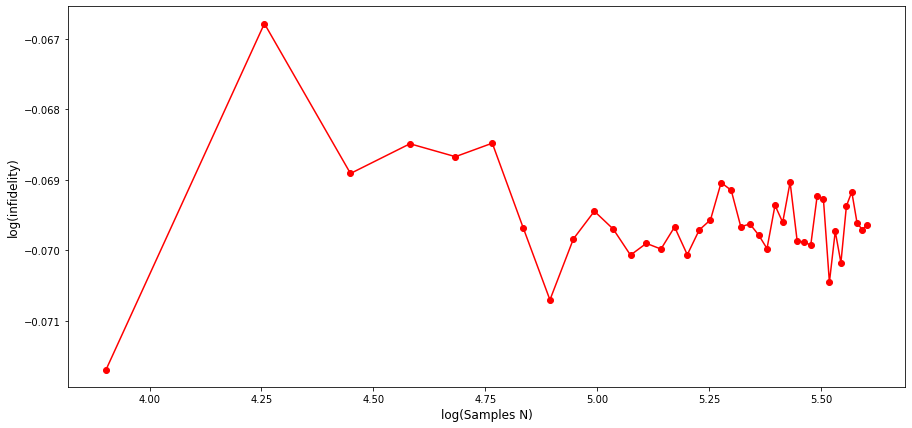

In [71]:
plt.figure (figsize = (15, 7))
plt.plot(np.log10(NValues), np.log10(Sample_infidel_N), 'ro-') 
plt.xlabel('log(Samples N)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

### Trotter S2 Performance

In [16]:
#Evaluate Trotter performance for varying t, done with AutoDiag functions from la

startTime = time.time()

tStart = 0.01
tFinal = 10
tSteps = 100
times = np.linspace(tStart, tFinal, tSteps)
temp_t = 3

r = 4000
#int(((temp_t**3)* 4 * (gamma**4))/(epsilon * 3)) #omitted alphacomm might be prohibitive
A_Trot_infidel_t = []

for t in times:
    Psi_t = (V_i) @ np.diag(np.exp(-1j*Y*t)) @ V_i_dagger @ InitialState #recalculate the exact solution
    #r = int(((t**3)* 4 * (gamma**4))/(epsilon * 3))
    A_Trot_infidel = S2_CompAuto(hj, Hlist, t, r, Psi_t)
    A_Trot_infidel_t.append(A_Trot_infidel)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 6.529064893722534


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


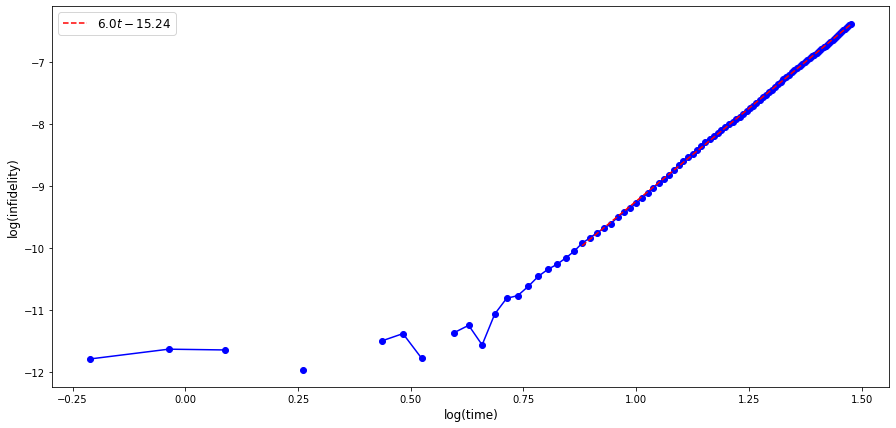

In [41]:
A_Trot_log_infidelity = np.log10(A_Trot_infidel_t)
A_Trot_log_time = np.log10(times)

plt.figure(figsize = (15, 7))
plt.plot(A_Trot_log_time, A_Trot_log_infidelity, 'bo-') 
plt.xlabel('log(time)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

fit_points = 25 #declare the starting point to fit in the data

p = np.polyfit(A_Trot_log_time[fit_points: -1], A_Trot_log_infidelity[fit_points: -1], 1)
f = np.poly1d(p)

t_new = np.linspace(A_Trot_log_time[fit_points], A_Trot_log_time[-1], 50)
y_new = f(t_new)

A_Trot_log_time = symbols("t")
poly = sum(S("{:6.2f}".format(v))*A_Trot_log_time**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

plt.plot(t_new, y_new, 'r--', label="${}$".format(eq_latex))
plt.legend(fontsize="large")
plt.show()

In [18]:
#Evaluate Trotter performance for varying t
del t
del Psi_t
startTime = time.time()

tStart = 0.01
tFinal = 30
tSteps = 100
times = np.linspace(tStart, tFinal, tSteps)
temp_t = 3

r = 4000
#int(((temp_t**3)* 4 * (gamma**4))/(epsilon * 3)) #omitted alphacomm might be prohibitive
Trot_infidel_t = []

for t in times:
    Psi_t = (V_i) @ np.diag(np.exp(-1j*Y*t)) @ V_i_dagger @ InitialState #recalculate the exact solution
    Trot_infidel = S2_Comp(hj, Hlist, t, r, Psi_t)
    Trot_infidel_t.append(Trot_infidel)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 6.209254741668701


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


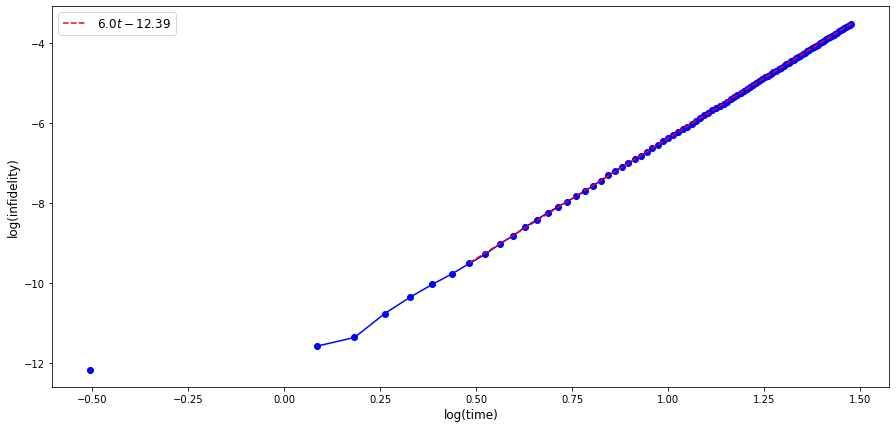

In [43]:
#print(Trot_infidel_t)
Trot_log_infidelity = np.log10(Trot_infidel_t)
Trot_log_time = np.log10(times)

plt.figure(figsize = (15, 7))
plt.plot(Trot_log_time, Trot_log_infidelity, 'bo-') 
plt.xlabel('log(time)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

fit_points = 10 #declare the starting point to fit in the data

p = np.polyfit(Trot_log_time[fit_points: -1], Trot_log_infidelity[fit_points: -1], 1)
f = np.poly1d(p)

t_new = np.linspace(Trot_log_time[fit_points], Trot_log_time[-1], 50)
y_new = f(t_new)

A_Trot_log_time = symbols("t")
poly = sum(S("{:6.2f}".format(v))*A_Trot_log_time**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

plt.plot(t_new, y_new, 'r--', label="${}$".format(eq_latex))
plt.legend(fontsize="large")
plt.show()

In [49]:
#Evaluate Trotter performance for varying r
startTime = time.time()

t_fixed = 1
r = (((t_fixed**3)* 4 * (gamma**4))/(epsilon * 3)) * (alphacomm/10) #omit alphacomm if prohibitive, omiited int to avoid rounding error
Psi_t = (V_i) @ np.diag(np.exp(-1j*Y*t_fixed)) @ V_i_dagger @ InitialState

rStart = 0.01 * r
rFinal = 5 * r
rSteps = 20
rValues = np.linspace(rStart, rFinal, rSteps)
rValues = [int(y+1) for y in rValues]

Trot_infidel_r = []
for i in rValues:
    Trotter_infidel = S2_Comp(hj, Hlist, t_fixed, i, Psi_t)
    Trot_infidel_r.append(Trotter_infidel)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 581.0602340698242


Text(0, 0.5, 'log(infidelity)')

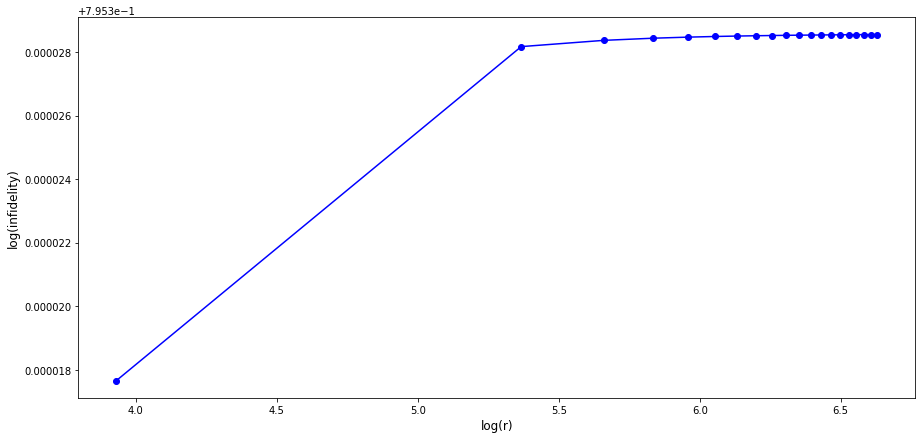

In [50]:
plt.figure (figsize = (15, 7))
plt.plot(np.log10(rValues), np.log10(Trot_infidel_r), "bo-") #Remove the squared to simply see the wavefunction
plt.xlabel('log(r)', size = 12)
plt.ylabel('log(infidelity)', size = 12)